# Crypto Analyzer

Actions: {Buy, Sell, Hold}

Goal: Max(Profit)

State: Position (crypto inventory)


## Limitations

- Buys "whole" coin only. Test it for BTC with 1M+.
- Always buys at first.
- Always sells at the end.

## Future work

- Fix limitations.
- Give it a portfolio and let it take best decision in real time.

## Visualization


In [13]:
from collections import deque

import requests


def get_historical_prices(pair, interval):
    url = 'https://api.kraken.com/0/public/OHLC'
    params = {
        'pair': pair,
        'interval': interval,
    }

    response = requests.get(url, params=params)
    data = response.json()

    if data['error']:
        raise Exception(f"API Error: {data['error']}")

    pair_name = list(data['result'].keys())[0]
    ohlc_data = data['result'][pair_name]

    prices = [float(entry[4]) for entry in ohlc_data]  # Closing prices
    timestamps = [int(entry[0]) for entry in ohlc_data]

    return prices, timestamps

In [14]:
def dfs(prices, budget, position, index, path, max_result):
    # Base condition
    if index == len(prices):
        total = budget + position * prices[-1]
        # choose the winning pathes only
        if total > max_result['profit']:
            max_result['profit'] = total
            max_result['path'] = path.copy()
        return

    # Try buying if not holding any position
    if position == 0 and budget >= prices[index]:
        dfs(
            prices,
            0,  # Spend all budget
            budget / prices[index],  # distribute the budget
            index + 1,  # next timestamp
            path + [('buy', index)],  # save path
            max_result  # save state
        )

    # Try selling if holding a position
    if position > 0:
        dfs(
            prices,
            budget + position * prices[index],
            0,  # Sell all holdings
            index + 1,
            path + [('sell', index)],
            max_result
        )

    # Hold
    dfs(
        prices,
        budget,
        position,
        index + 1,
        path + [('hold', index)],
        max_result
    )


In [15]:
def bfs(prices, budget):
    max_profit = 0
    best_path = []
    queue = deque()
    queue.append((budget, 0, 0, []))  # (budget, position, index, path)

    while queue:
        budget, position, index, path = queue.popleft()

        if index == len(prices):
            total = budget + position * prices[-1]
            if total > max_profit:
                max_profit = total
                best_path = path
            continue

        # Buy
        if position == 0 and budget >= prices[index]:
            queue.append((
                0,
                budget / prices[index],
                index + 1,
                path + [('buy', index)]
            ))

        # Sell
        if position > 0:
            queue.append((
                budget + position * prices[index],
                0,
                index + 1,
                path + [('sell', index)]
            ))

        # Hold
        queue.append((
            budget,
            position,
            index + 1,
            path + [('hold', index)]
        ))

    return max_profit, best_path

In [16]:
def heuristic_search(prices, budget):
    position = 0
    path = []
    for i in range(len(prices) - 1):
        # Simple heuristic: Buy if next price is higher, sell if lower
        if prices[i + 1] > prices[i] and position == 0 and budget >= prices[i]:
            # Buy
            position = budget / prices[i]
            budget = 0
            path.append(('buy', i))
        elif prices[i + 1] < prices[i] and position > 0:
            # Sell
            budget += position * prices[i]
            position = 0
            path.append(('sell', i))
        else:
            # Hold
            path.append(('hold', i))

    # Sell any remaining position at the end
    if position > 0:
        budget += position * prices[-1]
        path.append(('sell', len(prices) - 1))

    return budget, path

In [17]:
import matplotlib.pyplot as plt


def plot_positions(prices, timestamps, path, strategy_name):
    """
    Plots the prices and marks the buy and sell positions.

    :param prices: List of prices
    :param timestamps: List of timestamps corresponding to the prices
    :param path: List of actions taken (buy/sell/hold)
    :param strategy_name: Name of the strategy for the plot title
    """
    from datetime import datetime

    # Convert timestamps to datetime objects
    dates = [datetime.fromtimestamp(ts) for ts in timestamps]

    # Prepare buy and sell positions
    buy_indices = [action[1] for action in path if action[0] == 'buy']
    sell_indices = [action[1] for action in path if action[0] == 'sell']

    buy_dates = [dates[i] for i in buy_indices]
    buy_prices = [prices[i] for i in buy_indices]

    sell_dates = [dates[i] for i in sell_indices]
    sell_prices = [prices[i] for i in sell_indices]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(dates, prices, label='Price', color='blue')
    plt.scatter(buy_dates, buy_prices, marker='^', color='green', label='Buy', s=100)
    plt.scatter(sell_dates, sell_prices, marker='v', color='red', label='Sell', s=100)
    plt.title(f"{strategy_name} Strategy Trading Positions")
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


DFS Max Profit: 2131.2218134370364
DFS Best Path: [('hold', 0), ('buy', 1), ('hold', 2), ('hold', 3), ('hold', 4), ('hold', 5), ('hold', 6), ('sell', 7), ('buy', 8), ('sell', 9)]
BFS Max Profit: 2131.2218134370364
BFS Best Path: [('hold', 0), ('buy', 1), ('hold', 2), ('hold', 3), ('hold', 4), ('hold', 5), ('hold', 6), ('sell', 7), ('buy', 8), ('sell', 9)]
Heuristic Search Profit: 2131.2218134370364
Heuristic Search Path: [('hold', 0), ('buy', 1), ('hold', 2), ('hold', 3), ('hold', 4), ('hold', 5), ('hold', 6), ('sell', 7), ('buy', 8), ('sell', 9)]


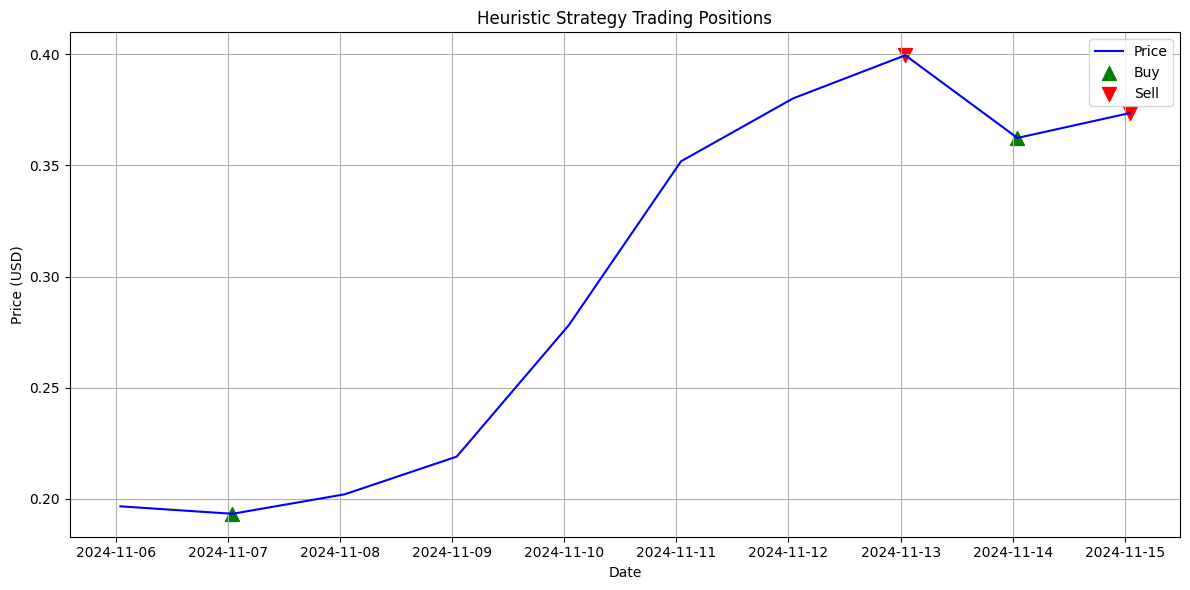

In [18]:
# Coin pain
pair = 'DOGEUSD'
interval = 1440  # Daily data

# Fetch historical prices
prices, timestamps = get_historical_prices(pair, interval)

n = -10 # days
prices = prices[n:]
timestamps = timestamps[n:]

# remember that the coin unit price can't be bigger than budget till now ;)
budget = 1000  # Starting budget in USD

# Depth-First Search
max_result_dfs = {'profit': 0, 'path': []}
dfs(prices, budget, 0, 0, [], max_result_dfs)
print("DFS Max Profit:", max_result_dfs['profit'])
print("DFS Best Path:", max_result_dfs['path'])
# plot_positions(prices, timestamps, max_result_dfs['path'], "DFS")

# Breadth-First Search
max_profit_bfs, best_path_bfs = bfs(prices, budget)
print("BFS Max Profit:", max_profit_bfs)
print("BFS Best Path:", best_path_bfs)
# plot_positions(prices, timestamps, best_path_bfs, "BFS")


# Heuristic Search
profit_heuristic, path_heuristic = heuristic_search(prices, budget)
print("Heuristic Search Profit:", profit_heuristic)
print("Heuristic Search Path:", path_heuristic)

plot_positions(prices, timestamps, path_heuristic, "Heuristic")